Progress: 100.0%  2021-06-30:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

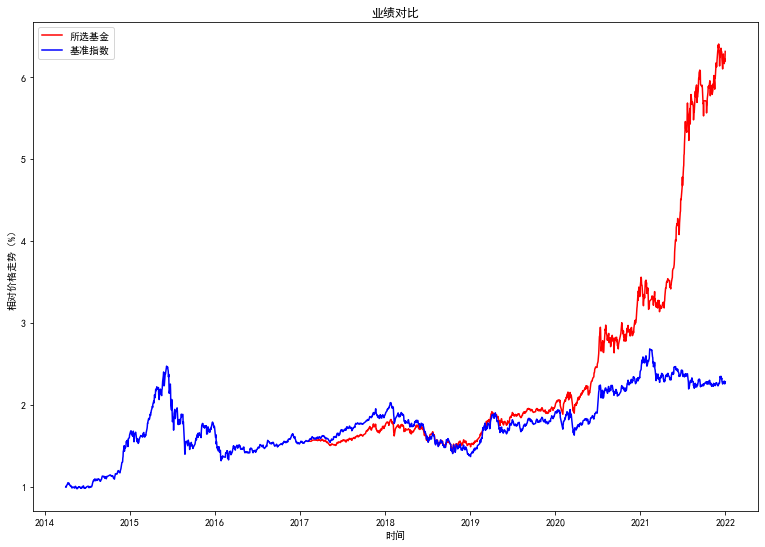

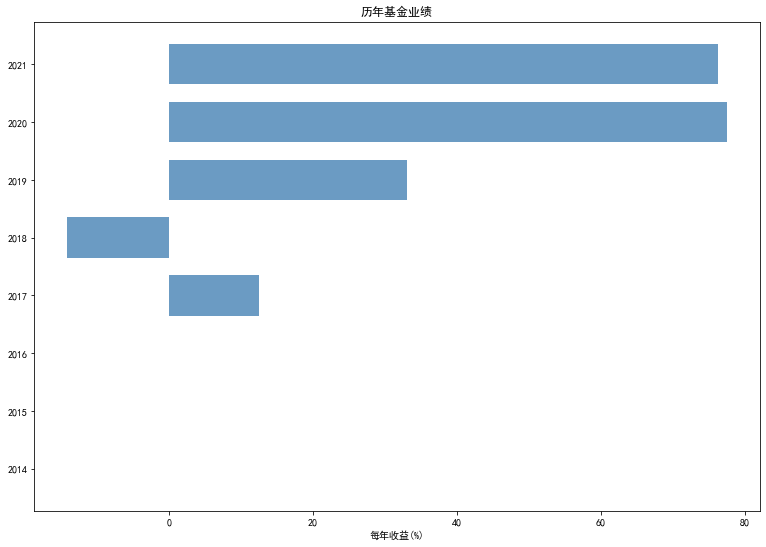

,超额收益TR,资产配置贡献AR,个股选择贡献SR,交互贡献IR
2018-12-31,-0.026677,-0.063336,0.101215,-0.064556
2019-06-30,-0.019259,-0.001048,-0.146978,0.128768
2019-12-31,0.055037,0.017463,0.054551,-0.016978
2020-06-30,0.101225,0.047196,0.007485,0.046544
2020-12-31,-0.204673,-0.040865,-0.150083,-0.013726
2021-06-30,0.273577,0.108593,0.063739,0.101245
2021-12-31,0.299610,0.037488,0.044412,0.217710


,Name,Value,Explenation
0,期间总超额收益,0.457704,"策略相对于基准获得的额外收益, 包含主动配置收益、标的选择收益以及交互效应收益"
1,期间总资产配置贡献,0.089309,主动配置的收益来源于对上涨行业的超配或对下跌行业的低配
2,期间总个股选择贡献,0.022821,标的选择的收益来源于对行业中表现好的个股的超配或对行业中表现差的个股的低配
3,期间总交互贡献,0.345574,超额收益中同时受到主动配置与标的选择影响的部分


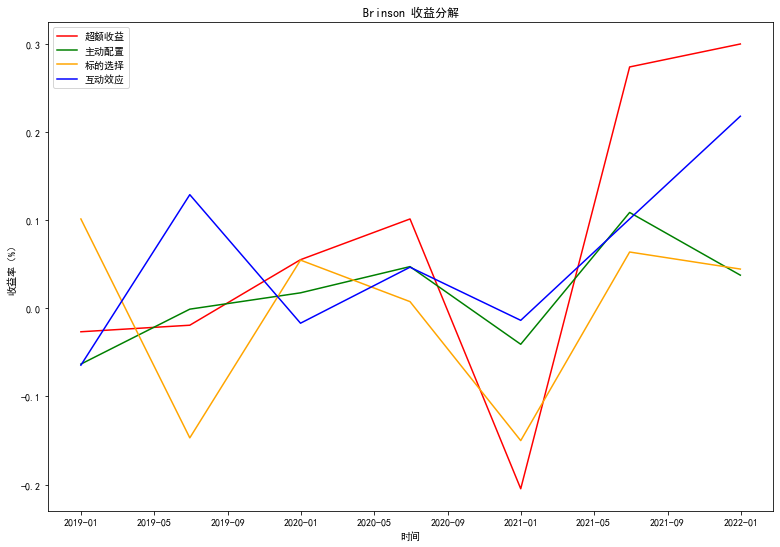

,行业,基准指数配置占比,基金配置占比,配置权重差（基金-基准）
0,农林牧渔,0.015067,0.007055,-0.008012
1,交运设备,0.000000,0.000000,0.000000
2,交通运输,0.030809,0.010314,-0.020494
3,休闲服务,0.010626,0.004304,-0.006321
4,信息服务,0.000000,0.000000,0.000000
5,信息设备,0.000000,0.000000,0.000000
6,公用事业,0.023839,0.008814,-0.015024
7,化工,0.026654,0.112401,0.085746
8,医药生物,0.083120,0.052176,-0.030944
9,商业贸易,0.006361,0.027348,0.020986


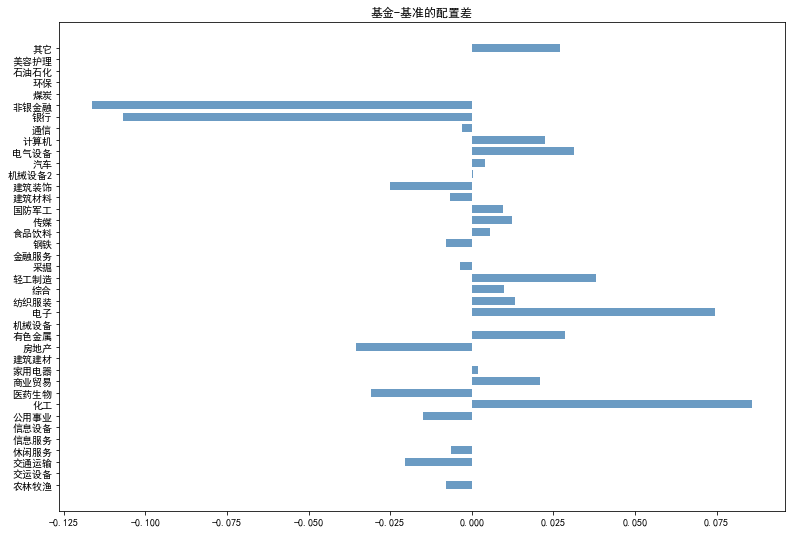

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, date
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
import sys


class Brinson_analysis : 
    #######################################
    #######################################
    # 数据导入
    def __init__(self, basic_index, fund_name, begin, end, default_date) : 
        self.BASIC_INDEX = basic_index
        self.FUND_NAME = fund_name
        self.BEGIN = begin
        self.END = end
        self.DATE = default_date
        
        """读取相关数据csv文件并生成df, 以及调整其他变量, 以供后面使用"""
        
        # 获取基金的净值变化信息 pnl: {index: [基金代码code, 日期day, 单位净值net_value, 累计净值sum_value, 
        #                                 复权因子factor, 累计复权因子acc_factor, 累计复权净值refactor_net_value]}
        self.pnl = pd.read_csv('data/fund_data/' + fund_name + '_pnl.csv').sort_values(by='day') 
        # 获取基金的持股信息 stocks: {index: [基金代码code,  开始日期period_start,  报告期period_end,  公告日期pub_date, 
        #                                 股票代码symbol, 持有份数shares, 持有股票的市值market_cap,  占净值比例proportion]}
        self.stocks = pd.read_csv('data/fund_data/' + fund_name + '_stocks.csv').sort_values(by='period_start')

        # 获取申万一级行业信息, 由于有些股票无分类, 故加入800000表示其他; 因为机械设备对应两个code, 为防错误将后面的名称修改为机械设备2以区分
        # sw_indus_df: 申万一级行业的信息表{columns: [行业代码code, 行业名称name, 开始日期start_date, 修改后的名称name_change]}
        self.sw_indus_df = (pd.read_csv('data/industries/industries.csv')).astype('str')
        self.sw_indus_df = self.sw_indus_df.append({'code':'800000','name':'其它','name_change':'其它'},ignore_index=True)

        # 基准指数的行情信息, 用申万一级指数的变化表示基准指数在各个行业的收益变化
        # sw_indus_close_df: 申万一级各行业收盘价{columns: 各行业代码codes; index: date; values: 收盘价}
        self.sw_indus_close_df = pd.read_csv('data/industries/sw_industries_close_df.csv').set_index('date').sort_index()
        # 这里提前下载了沪深300指数的收盘价作为行业代码800000并入, 后续会修改为其他csv导入并合并, 便于更换基准指数
        basic_index_prices = pd.read_csv('data/industries/sw_industries_close_df.csv').set_index('date').sort_index()['800000']
        self.basic_index_prices = basic_index_prices[(basic_index_prices.index >= str(begin)) & (basic_index_prices.index <= str(end))]

        # 获取所有股票价格信息 all_stock_close: {columns: 各股代码codes; index: date; values: 收盘价}
        self.all_stock_close = pd.read_csv('data/stock_close.csv').set_index('date').sort_index()

        # 获取基准指数的持股信息 basic_weight_df: {columns: [股票代码code, date, 持有权重weight, 股票中文display_name]}
        basic_weight_df = pd.read_csv('data/index/' + basic_index + '.csv').set_index('code')
        self.basic_weight_df = basic_weight_df.drop_duplicates()
        
        # 获取股票行业分类的基本信息 industry_classifer:{columns: 各个stock code; index: date; values: stock在date所属申万一级行业的code}
        self.industry_classifer = pd.read_csv('data/industries/stock_index_classifer.csv').set_index('date').fillna('800000')
        self.industry_classifer = self.industry_classifer.astype('int').astype('str') # 将excel中的诸如801010.00格式改为'801010'
        
        # 将数据中的日期格式从str统一更改为timestamp
        self.stocks.period_start = pd.to_datetime(self.stocks.period_start)
        self.stocks.period_end = pd.to_datetime(self.stocks.period_end)
        self.pnl.day = pd.to_datetime(self.pnl.day)
        self.sw_indus_close_df.index = pd.to_datetime(self.sw_indus_close_df.index)
        self.basic_index_prices.index = pd.to_datetime(self.basic_index_prices.index)
        self.all_stock_close.index = pd.to_datetime(self.all_stock_close.index)
        self.BEGIN = pd.to_datetime(self.BEGIN)
        self.END = pd.to_datetime(self.END)
        self.DATE = pd.to_datetime(self.DATE)
        self.basic_weight_df.date = pd.to_datetime(self.basic_weight_df.date)
        self.industry_classifer.index = pd.to_datetime(self.industry_classifer.index)

        # 只挑选起始1月结束6或12月的报告, 即半年报和年报的数据, 剔除季报数据, 用它们的结束日期作为每个period的间隔
        def choose_date(x,month_value) : 
            if x.month in month_value : 
                return x
        prd_start = self.stocks.period_start.apply(choose_date,args = ([1],)) 
        prd_end = self.stocks.period_end.apply(choose_date,args = ([6,12],))
        periods_df = pd.concat([prd_start,prd_end],axis=1).dropna().drop_duplicates()  
        # 导出每一次报告日。这里认为每个报告日发布的组合配置会保持直到下个报告日的报告更新, 即报告期的end是我们持有组合的begin
        ends = np.array(periods_df.period_end)
        ends = sorted(set(ends[(ends < self.END) & (ends >= self.BEGIN)]))
        # 每两个时间戳之间的间隔为一个持有期, 如果END离最后一个报告日时间间隔过大（30day）, 也将这段时间考虑入brinson分析中来
        if (self.END - ends[-1]).days >= 30 : 
            self.periods = sorted(ends + [self.END])
        else : self.periods = ends
        self.periods = pd.to_datetime(self.periods)
        self.periods_len = len(self.periods) - 1

    #######################################
    #######################################
    # 辅助函数块 1 - 单期brinson计算:  
    def get_industry(self, codes, date) : 
        """
        func 获取各个股票对应的各个行业code, 如果没有对应行业输出800000表示无对应行业
        input 股票代码(list), 日期date(timestamp)
        output 对应的行业指数code(series, index为stock, value为行业code)
        """
        industry_classifer_series = self.industry_classifer.loc[self.industry_classifer.index <= date, :].sort_index().iloc[-1]
        mask = pd.Series(codes).isin(industry_classifer_series.index)
        industry_classifer_series = pd.concat([industry_classifer_series, pd.Series(index=np.array(codes)[~mask])]).fillna('800000')
        return industry_classifer_series[codes]
    
    
    def change_code_form(self, name):
        """
        func 调整股票code的格式, 原因是joinquant下载的基金持股的股票数据格式诸如000123, 
            且在excel下会变成int 123, 而其他股票数据格式诸如'000123.XSHE', 这里做统一
        input 各股票的几位数名字(int)。
        output 对应的更新格式过后的股票code(int)
        """
        name = str(int(name))
        name = '0'* (6 - len(name)) + name
        if int(name) >= 600000: 
            name += '.XSHG'  
        else :
            name += '.XSHE'
        return name
    
    def compu_stocks_returns(self, codes, begin, end):
        """
        func 获取股票对应起止日期间的收益率
        input 各股票的代码code(list), 起始日期begin和结束日期end(timestamp)
        ouput 该期间对应股票的回报return_series(series, index stock, values return)
        """
        mask = pd.Series(codes).isin(self.all_stock_close.columns)
        if False in mask : 
            self.all_stock_close = pd.concat([self.all_stock_close, pd.DataFrame(columns=np.array(codes)[~mask])], axis = 1)
        begin_close_series = self.all_stock_close.loc[self.all_stock_close.index >= begin, codes].sort_index().iloc[0]
        end_close_series = self.all_stock_close.loc[self.all_stock_close.index <= end, codes].sort_index().iloc[-1]
        return_series = end_close_series / begin_close_series - 1
        return_series[~(return_series<100)] = 0
        return return_series
    
    def get_fund_w_r(self, weights_, returns_, default_date):
        """
        func 计算基金的各行业权重w和各行业收益率r, 由于一个行业内有多只权重不同的股票, 
                计算某一行业的期间收益时选择将行业内持有的股票收益率按当前权重加权平均, 
                如某行业内所有持股权重0.01, 0.02, 0.03, 则行业收益率为(0.01a+0.02b+0.03c)/(0.01+0.02+0.03)
        input 基金当前持股的权重weights_(series, index stock, values weights), 
            基金当前持股的期间收益率returns_(series, index stock, values returns), 
            日期default_date(timestamp), 用于获取default_date日期时各个股票对应的行业
        return 基金当前在各个行业的权重weight(series, index industries, values weights), 
            基金当前在各个行业的期间收益率returns(series, index industries, values returns), 
        """
        # 查询各股票对应的行业
        codes = list(weights_.index)
        stock_indus = self.get_industry(codes, default_date)

        # 按顺序输出所有行业, 一一查询对应的权重
        w_r_df = pd.concat([stock_indus, weights_, returns_],axis = 1) # index stocks
        w_r_df.columns = ['industry','weights', 'stock_returns']
        industry_weight = w_r_df.groupby('industry').sum().weights  # index indus; columns weights

        w_r_df['industry_weight'] = 0

        for industry_ in industry_weight.index :  ### 
            w_r_df.loc[w_r_df.industry == industry_, 'industry_weight'] = industry_weight[industry_]
        w_r_df['stock_weighted_returns'] = w_r_df['stock_returns'] * w_r_df['weights'] / w_r_df['industry_weight']
#         w_r_df[['industry_weight', 'stock_weighted_returns']] = w_r_df[['industry_weight', 'stock_weighted_returns']].astype('float')
        industry_returns = w_r_df.groupby('industry').sum().stock_weighted_returns  # index indus; columns returns

        res = pd.concat([industry_weight, industry_returns],axis = 1)    # index indus; columns weights, returns

        # 可能存在本轮股票未涉及到的行业, 这里填充上
        mask = pd.Series(self.sw_indus_df.code).isin(res.index)
        res = pd.concat([res, pd.DataFrame(index=np.array(self.sw_indus_df.code)[~mask])], axis = 0)
        res = res.loc[self.sw_indus_df.code]
        res.fillna(0, inplace = True)    

        return res.weights, res.stock_weighted_returns    
    
    def get_indus_basic_returns(self, begin, end):
        """
        func 获取基准指数各个行业的期间收益率（即申万一级行业指数变化）以及基准指数总的收益率
        input 起止日期begin, end(timestamp)
        output 申万各行业指数的回报率（其它行业800000用沪深300指数的回报替代）(list)以及基本指数的回报率(float)
        """
        close_df = self.sw_indus_close_df[self.sw_indus_df.code]
        begin_close = close_df[close_df.index >= str(begin)].sort_index().iloc[0]
        end_close = close_df[close_df.index <= str(end)].sort_index().iloc[-1]
        indus_index_return = list((end_close / begin_close - 1).fillna(0))  # 有些行业指数已经废弃, 这里不再产生return, 故将nan赋值为0

        # 计算基本指数的回报率
        basic_index_return = end_close['800000'] / begin_close['800000'] - 1

        return indus_index_return, basic_index_return

    def get_basic_weights(self, date, default_date):
        """
        func 获取基准指数的各个申万一级行业的权重
        input 对应日期date(timestamp); 日期default_date(timestamp), 用于获取default_date日期时各个股票对应的行业
        output 各行业权重 basic_weight(list)
        """
        # get_index_weights  对于基本指数BASIC_INDEX和某特定日期date, 输出该日的成分股权重df
        index_weight_date = np.array(sorted(np.unique(self.basic_weight_df.date.values)))
        date_latest = index_weight_date[index_weight_date <= pd.to_datetime(date)][-1]  # 获取basic weight里离当前date最近的过去一天
        df = self.basic_weight_df[(self.basic_weight_df.date == str(date_latest))]
        weights_series = df.weight/100
        basic_weight = self.get_indus_group_value(weights_series, date, default_date)
        return basic_weight
    
    def get_indus_group_value(self, weights_series, date, default_date):
        """
        func 将各个股票的数据groupby加总为行业的数据, 这里是用来将基准指数的各个股票的权重加总为基准指数的各行业权重
        input 基金指数持股权重weights_series(series, index stock, values weight);
            对应日期date(timestamp); 日期default_date(timestamp), 用于获取default_date日期时各个股票对应的行业
        output 各行业权重res(list)
        """
        # 查询各股票对应的行业
        codes = weights_series.index
        values_ = weights_series
        stock_indus = self.get_industry(codes, default_date)
        # groupby 加总行业内权重
        group_sum_df = pd.DataFrame([stock_indus, values_],index = ['industry','values_']).T.groupby('industry').sum()
        # 对本周期未涉及到的行业，也合并入df并赋权重0
        mask = pd.Series(self.sw_indus_df.code).isin(group_sum_df.index)
        group_sum_df = pd.concat([group_sum_df, pd.DataFrame(index=np.array(self.sw_indus_df.code)[~mask])], axis = 0).fillna(0)
        group_sum_df = group_sum_df.loc[self.sw_indus_df.code].values_.to_list()

        return group_sum_df

    def single_period_brinson(self) : 
        """
        func 开始第一阶段计算, 对每个报告日间的持股brinson单期分析, 生成每个period间的各超额收益TR SR AR IR等
        input Null
        output Null(将以下变量与self绑定以供后续调用: 
                    brinson分析需要用到的四种超额属性TRs, ARs, SRs, IRs, (list) 
                    基金和基准指数的各period持股的各行业权重情况deploy_fund,deploy_index(list) )
        """
        TRs, ARs, SRs, IRs = [], [], [], []
        deploy_fund  = list(np.zeros(len(self.sw_indus_df.code)))
        deploy_index = list(np.zeros(len(self.sw_indus_df.code)))
        
        for i in range(self.periods_len):
            begin, end = self.periods[i], self.periods[i+1]
            # 显示进度条
            print("\r", end="")
            print("Progress: {0}%  {1}: ".format(round((i+1)/self.periods_len * 100,3),(begin).to_pydatetime().date()), 
                  "▋" * int(i /self.periods_len * 50), end="")
            sys.stdout.flush()
            
            # 找出这一时间段对应的股票名 和 市值, 并计算出各自的占比, 收益
            corr_stocks_df = self.stocks.loc[self.stocks['period_end'] == begin,['symbol','market_cap']]
            corr_stocks_df['weight'] = corr_stocks_df['market_cap'] / (corr_stocks_df['market_cap'].sum())
            corr_stocks_df['symbol'] = corr_stocks_df['symbol'].apply(self.change_code_form)
            corr_stocks = corr_stocks_df['symbol'].to_list()
            weights = corr_stocks_df.set_index('symbol').weight
            
            # 计算沪深300 指数的各行业占比 和回报率
            stock_returns = self.compu_stocks_returns(corr_stocks, begin, end)

            # 计算基金的各股票归属的行业,  占比和回报
            w_fund, r_fund = self.get_fund_w_r(weights, stock_returns, default_date = self.DATE) 
            # w_fund 即是该期基金实际分配到各行业的资金比例

            # 计算沪深300 指数的各行业占比 和回报率
            w_basic = self.get_basic_weights(begin, default_date = self.DATE)
            r_basic, basic_index_return = self.get_indus_basic_returns(begin, end)

            # 计算基金本期收益, 基准收益, 超额收益
            R = sum(np.array(w_fund) * np.array(r_fund))
            Rm = basic_index_return
            TR = R - Rm
            TRs.append(TR)
            # 计算资产配置贡献,  个股选择贡献,  交互贡献
            AR = sum((np.array(w_fund) - np.array(w_basic)) * np.array(r_basic))
            SR = sum((np.array(r_fund) - np.array(r_basic)) * np.array(w_basic))
            IR = TR - AR -SR
            ARs.append(AR)
            SRs.append(SR)
            IRs.append(IR)

            # 更新基金和指数在各行业的配置占比
            deploy_fund = list(np.array(deploy_fund) + np.array(w_fund))
            deploy_index = list(np.array(deploy_index) + np.array(w_basic))
        self.TRs, self.ARs, self.SRs, self.IRs = TRs, ARs, SRs, IRs
        self.deploy_fund = deploy_fund
        self.deploy_index = deploy_index
#         self.w_fund,self.r_fund,self.w_basic,self.r_basic = w_fund,r_fund,w_basic,r_basic
        return #TRs, ARs, SRs, IRs, deploy_fund, deploy_index


    
    #######################################
    #######################################
    # 辅助函数块 2:  将各个period的单期brinson分析连接为多期brinson分析
    def calc_linking_factor(self, portfolio, benchmark):
        """
        func 进行多期业绩的合并; 使用 Carino联接因子方法
        input 基金的对数收益率portfolio(list), 基准指数的对数收益率benchmark(list)
        ouput Carino联接因子k_ts(list)
        """
        r, b = np.array(portfolio).prod(), np.array(benchmark).prod()
        k = (np.log1p(r) - np.log1p(b))/(r - b)
        k_ts = []
        for i in range(len(portfolio)):
            if portfolio[i] == benchmark[i]:
                k_ts.append(1/(1+portfolio[i]))
            else:
                k_t = (np.log1p(portfolio[i]) - np.log1p(benchmark[i]))/(portfolio[i] - benchmark[i])
                k_ts.append(k_t)
        return k_ts

    def compute_res(self, prices):
        """
        func 将价格或净值转化为对数收益率
        input 价格或净值list
        output 对数收益率list
        """
        res = []
        for i in range(len(prices) - 1):
            re = np.log1p(prices[i+1]) - np.log1p(prices[i])
            res.append(re)
        return res

    def find_close_date(self, date_list):
        """
        func 获取上一交易日
        input 时间(list(Timestamp))
        output 距该时间戳之后最近的是交易日的时间(list(Timestamp))(对于最后一个, 需要是之前最近的交易日)
        """
        df = self.basic_index_prices.copy(deep=True)
        df.index = pd.to_datetime(df.index)
        alist = []
        for day in date_list:
            day = datetime.combine(day.to_pydatetime().date(), datetime.min.time())
            last_day = datetime.combine(pd.to_datetime(date_list)[-1], datetime.min.time())
            if day < last_day:
                # 输出之后的最近交易日 
                adate = df[df.index >= day].index[0]
            else:
                adate = df[df.index <= day].index[-1]
            alist.append(adate)

        return alist

    def compu_periods_res(self, periods):
        """
        func 获取各个时间段periods内的基金和指数的各期业绩的回报, 其使用除法算法
        input 各个交易期时间节点periods(list(Timestamp))
        output 基金和指数的各期业绩的回报fund_res, index_res(list), 其使用除法算法
        """
        date_list2 = self.find_close_date(periods)
        # 获得基金的各点的值
        df_fund = self.pnl.set_index('day')
        df_fund.index = pd.to_datetime(df_fund.index)

        # 获得指数的各点的价格
        df_index = self.basic_index_prices.copy(deep=True)
        # 存在日期基金当日没有数据而指数有, 对齐 ### 可以考虑用指数的日期来ffill
        for line in list(set(df_fund.index) - set(df_index.index)):
            df_index.loc[line] = None
        df_index = df_index.sort_index().ffill()
        for line in list(set(df_index.index) - set(df_fund.index)):
            df_fund.loc[line] = None
        df_fund = df_fund.sort_index().ffill()
        moneys = df_fund[df_fund.index.isin(date_list2)].sum_value.sort_index()
        closes = df_index[df_index.index.isin(date_list2)].sort_index()
        moneys = list(moneys)
        closes = list(closes)

        # 计算回报率
        fund_res = self.compute_res(moneys)
        index_res = self.compute_res(closes)

        return fund_res, index_res

    def multi_periods_brison(self): #(periods_list = None, ARs_list, SRs_list, IRs_list):
        """
        func 正式开始计算 多期Brinson模型的综合结果 (和一般算法有些不同, 因为我们在起初就使用了对数收益率)
        input Null
        output Null(将以下变量与self绑定以供后续调用: 
                    brinson分析需要用到的四种超额属性AR_final, SR_final, IR_final, TR_final,(float) 表示总期间内的四种超额属性的情况)
        """
        periods_list = self.periods
        self.single_period_brinson()  # 运算出AR, SR, IR, TR, 和行业配置情况
        ARs_list, SRs_list, IRs_list = self.ARs, self.SRs, self.IRs
        fund_res, index_res = self.compu_periods_res(periods_list)
        k_ts = self.calc_linking_factor(fund_res,index_res)
        #最终业绩分析
        AR_final = sum(np.array(k_ts) * np.array(ARs_list))
        SR_final = sum(np.array(k_ts) * np.array(SRs_list))
        IR_final = sum(np.array(k_ts) * np.array(IRs_list))
        TR_final = AR_final + SR_final + IR_final
        
        self.AR_final, self.SR_final, self.IR_final, self.TR_final = AR_final, SR_final, IR_final, TR_final
        return # AR_final, SR_final, IR_final, TR_final
    
    #######################################
    #######################################
    # brinson分析结果展示

    def result_display(self) : 
        """用来一次输出下面的四个result_display_开头的结果展示函数, 如有需要也可以挑选各个函数分别输出"""
        fig_perform_compar, fig_fund_perform = self.result_display_fund_perform()
        brinson_period, brinson_whole = self.result_display_brinson_df()
        fig_return_decompose = self.result_display_brinson_plot()
        industries_panel, fig_diff = self.result_display_deploy_difference() 
        return fig_perform_compar, fig_fund_perform, brinson_period, brinson_whole, fig_return_decompose, industries_panel, fig_diff
        
    def result_display_fund_perform(self):
        """基金业绩对比图"""
        self.pnl.day = (self.pnl.day).dt.date
        fund_perf = self.pnl[self.pnl.day >= self.BEGIN][self.pnl.day <= self.END].sum_value.tolist()
        index_perf = self.basic_index_prices.tolist()
        fund_perf = list(np.array(fund_perf)/fund_perf[0])
        index_perf = list(np.array(index_perf)/index_perf[0])
        x_data = (self.pnl[self.pnl.day >= self.BEGIN][self.pnl.day <= self.END].day).values
        fig=plt.figure(figsize=(13, 9))
        
        # 有些fund在BEGIN之后很久才开始运行，这里将fund运行第一天的相对价格和基准对齐，便于之后日期的比较
        date_ = pd.to_datetime(x_data)[0]  # 获取基金运行的第一天
        d_list = np.array(pd.to_datetime(self..basic_index_prices.index))  # 基准指数的运行时间array
        index_loc = np.where(d_list==d_list[d_list>date_][0])[0][0]  # 基金开始运行后的第一个交易日对应基准指数运行时间的index
        fund_perf = np.array(fund_perf) * index_perf[index_loc]  # 调整基金相对价格
        
        # 让plt可以显示中文
        plt.rcParams['font.sans-serif']=['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        # 画两个曲线的对比图
        plt.title('业绩对比')
        plt.plot(x_data, fund_perf, color='red',  label='所选基金')
        plt.plot(self.basic_index_prices.index, index_perf, color='blue', label='基准指数')
        plt.legend() 

        plt.xlabel('时间')
        plt.ylabel('相对价格走势（%）')
        plt.show()
        fig_perform_compar = fig
        ################################
        # 基金 年化收益
        re_list = []
        year_list = []
        year = self.BEGIN.year + 1
        for i in range(self.END.year - self.BEGIN.year):
            re = (self.pnl[self.pnl.day >= date(year, 1, 1)].sum_value.tolist()[0]/self.pnl[self.pnl.day >= date(year - 1, 1, 1)].sum_value.tolist()[0] - 1)*100
            re_list.append(re)
            year_list.append(year-1)
            year = year + 1 
        fig=plt.figure(figsize=(13, 9))
        plt.barh(range(self.END.year - self.BEGIN.year), re_list, height=0.7, color='steelblue', alpha=0.8)      # 从下往上画
        plt.yticks(range(self.END.year - self.BEGIN.year), year_list)
        # plt.xlim(30,47)
        plt.xlabel("每年收益(%)")
        plt.title("历年基金业绩")

        plt.show()    
        fig_fund_perform = fig
        return fig_perform_compar, fig_fund_perform

    def result_display_brinson_df(self):
        """输出Brinson分析的结果, 并分析该基金 """
        brinson_period = pd.DataFrame({'超额收益TR':(np.array(self.ARs) + np.array(self.SRs) + np.array(self.IRs)),
                      '资产配置贡献AR': np.array(self.ARs), 
                      '个股选择贡献SR': np.array(self.SRs) , 
                      '交互贡献IR': np.array(self.IRs)},
                     index = self.periods[1:])
        display(brinson_period)
        ################################
        # 输出Brinson分析的结果, 并分析该基金 
        Name = ["期间总超额收益","期间总资产配置贡献","期间总个股选择贡献","期间总交互贡献"]
        Value = [self.TR_final,self.AR_final,self.SR_final,self.IR_final]
        Explenation = [ "策略相对于基准获得的额外收益, 包含主动配置收益、标的选择收益以及交互效应收益", 
                        "主动配置的收益来源于对上涨行业的超配或对下跌行业的低配", 
                        "标的选择的收益来源于对行业中表现好的个股的超配或对行业中表现差的个股的低配", 
                        "超额收益中同时受到主动配置与标的选择影响的部分"]
        brinson = {"Name":Name, "Value":Value,"Explenation":Explenation}
        brinson_whole = pd.DataFrame(brinson)
        display(brinson_whole)
        return brinson_period, brinson_whole

    def result_display_brinson_plot(self) : 
        """对比不同时间段的起作用的收益部分"""
        x_axix = self.periods[1:]
        fig=plt.figure(figsize=(13, 9))
        plt.title('Brinson 收益分解')
        plt.plot(x_axix, self.TRs, color='red',  label='超额收益')
        plt.plot(x_axix, self.ARs, color='green',    label='主动配置')
        plt.plot(x_axix, self.SRs, color='orange', label='标的选择')
        plt.plot(x_axix, self.IRs, color='blue',   label='互动效应')
        plt.legend() 

        plt.xlabel('时间')
        plt.ylabel('收益率（%）')
        plt.show()
        return fig
    
    def result_display_deploy_difference(self) : 
        """观察基金 和 指数 分别的在各行业的历史平均配置仓位"""
        deploy_fund_final = list(np.array(self.deploy_fund)/self.periods_len)
        deploy_index_final = list(np.array(self.deploy_index)/self.periods_len)
        deploy_minus = list(np.array(deploy_fund_final ) - np.array(deploy_index_final))

        industries_panel = {"行业":self.sw_indus_df.name_change,"基准指数配置占比":deploy_index_final,"基金配置占比":deploy_fund_final,
                           "配置权重差（基金-基准）":deploy_minus}
        industries_panel = pd.DataFrame(industries_panel)
        display(industries_panel)

        ################################
        # 各行业基金 - 基准的 配置差 
        fig=plt.figure(figsize=(13, 9))
        plt.barh(range(len(deploy_minus)), deploy_minus, height=0.7, color='steelblue', alpha=0.8)      # 从下往上画
        plt.yticks(range(len(deploy_minus)), self.sw_indus_df.name_change)
        plt.title("基金-基准的配置差")

        plt.show()
        return industries_panel, fig


if __name__ == "__main__":
    # 设置基本参数
    BASIC_INDEX = "000300.XSHG"   # 采用沪深300作为基准指数
    FUND_NAME = "003567"
    BEGIN = '2014-04-01'
    END = '2022-01-01'
    DATE = "2020-01-01"  # 因为对于申万一级行业指数曾经发生过改变，故需取最近的表格，这里选用DATE时的行业分类，后续可能会改为根据日期调整

    model = Brinson_analysis( BASIC_INDEX, FUND_NAME, BEGIN, END, DATE)
    model.multi_periods_brison()
    fig_perform_compar, fig_fund_perform, brinson_period, brinson_whole, fig_return_decompose, industries_panel, fig_diff = model.result_display()

#     brinson_period.to_csv('result/' + model.FUND_NAME + '_历年brinson单期分析.csv',encoding="utf_8_sig")
#     brinson_whole.to_csv('result/' + model.FUND_NAME + '_2014年至今总体brinson分析.csv',encoding="utf_8_sig")
#     industries_panel.to_csv('result/' + model.FUND_NAME + '_基金基准的配置差.csv',encoding="utf_8_sig")
#     fig_perform_compar.savefig('result/' + model.FUND_NAME + '_基金基准业绩比较.png')        
#     fig_fund_perform.savefig('result/' + model.FUND_NAME + '_历年基金业绩.png')        
#     fig_return_decompose.savefig('result/' + model.FUND_NAME + '_Brinson收益分解.png')       
#     fig_diff.savefig('result/' + model.FUND_NAME + '_基金基准的配置差.png')
